# SageMaker - Experiments - Tensorflow - Using Notebook

**Steps:**

- Download and prepare the dataset.

- Train an Artificial Neural Network (ANN) Model. Tune the hyper parameter that configures the number of `epochs` and the `learning_rate` in the model. Track the parameter configurations and resulting model `validation loss` using SageMaker Experiments Python SDK.

- Finally, use the search and analytics capabilities of Python SDK to search, compare, evaluate and visualize the performance of all model versions generated from model tuning in Step 2.

#### Install Packages

In [1]:
import sys

!{sys.executable} -m pip install matplotlib

#### Setup

In [2]:
import os
import time
import boto3
import itertools
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sagemaker.tensorflow import TensorFlow
import sagemaker
from sagemaker import get_execution_role

In [3]:
sess = boto3.Session()
sm = sess.client("sagemaker")
role = get_execution_role()
sagemaker_session = sagemaker.Session(boto_session=sess)
bucket = sagemaker_session.default_bucket()
prefix = "tf2-california-housing-experiment"

#### Download Dataset

In [4]:
data_dir = os.path.join(os.getcwd(), "data")
os.makedirs(data_dir, exist_ok=True)

train_dir = os.path.join(os.getcwd(), "data/train")
os.makedirs(train_dir, exist_ok=True)

test_dir = os.path.join(os.getcwd(), "data/test")
os.makedirs(test_dir, exist_ok=True)

data_set = fetch_california_housing()

X = pd.DataFrame(data_set.data, columns=data_set.feature_names)
Y = pd.DataFrame(data_set.target)

# We partition the dataset into 2/3 training and 1/3 test set.
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

np.save(os.path.join(train_dir, "x_train.npy"), x_train)
np.save(os.path.join(test_dir, "x_test.npy"), x_test)
np.save(os.path.join(train_dir, "y_train.npy"), y_train)
np.save(os.path.join(test_dir, "y_test.npy"), y_test)

In [5]:
s3_inputs_train = sagemaker.Session().upload_data(
    path="data/train", bucket=bucket, key_prefix=prefix + "/train"
)
s3_inputs_test = sagemaker.Session().upload_data(
    path="data/test", bucket=bucket, key_prefix=prefix + "/test"
)
inputs = {"train": s3_inputs_train, "test": s3_inputs_test}
print(inputs)

{'train': 's3://sagemaker-us-east-2-782329204437/tf2-california-housing-experiment/train', 'test': 's3://sagemaker-us-east-2-782329204437/tf2-california-housing-experiment/test'}


#### Step 1 - Set up the Experiment

Create an experiment to track all the model training iterations. Experiments are a great way to organize your data science work. You can create experiments to organize all your model development work.

#### Create an Experiment

In [6]:
!pip install sagemaker-experiments

In [7]:
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

In [8]:
california_housing_experiment = Experiment.create(
    experiment_name=f"tf2-california-housing-{int(time.time())}",
    description="Training on california housing dataset",
    sagemaker_boto_client=sm,
)
print(california_housing_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f73df611358>,experiment_name='tf2-california-housing-1651635763',description='Training on california housing dataset',tags=None,experiment_arn='arn:aws:sagemaker:us-east-2:782329204437:experiment/tf2-california-housing-1651635763',response_metadata={'RequestId': '39d73259-0786-480f-982c-5dfd9878252f', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '39d73259-0786-480f-982c-5dfd9878252f', 'content-type': 'application/x-amz-json-1.1', 'content-length': '105', 'date': 'Wed, 04 May 2022 03:42:42 GMT'}, 'RetryAttempts': 0})


#### Step 2 - Track Experiment

Create a Trial for each training run to track its inputs, parameters, and metrics.

In [10]:
#hyperparam_options = {"learning_rate": [0.1, 0.5, 0.9], "epochs": [100, 200]}
hyperparam_options = {"learning_rate": [0.1, 0.5], "epochs": [5, 10]}

hypnames, hypvalues = zip(*hyperparam_options.items())
trial_hyperparameter_set = [dict(zip(hypnames, h)) for h in itertools.product(*hypvalues)]
trial_hyperparameter_set

[{'learning_rate': 0.1, 'epochs': 5},
 {'learning_rate': 0.1, 'epochs': 10},
 {'learning_rate': 0.5, 'epochs': 5},
 {'learning_rate': 0.5, 'epochs': 10}]

In [12]:
from sagemaker.tensorflow import TensorFlow

run_number = 1

for trial_hyp in trial_hyperparameter_set:

    # Combine static hyperparameters and trial specific hyperparameters
    hyperparams = trial_hyp

    # Create unique job name with hyperparameter and time
    time_append = int(time.time())
    hyp_append = "-".join([str(elm).replace(".", "-") for elm in trial_hyp.values()])
    training_job_name = f"tf2-california-housing-training-{hyp_append}-{time_append}"
    trial_name = f"trial-tf2-california-housing-training-{hyp_append}-{time_append}"
    trial_desc = f"my-tensorflow2-california-housing-run-{run_number}"

    # Create a new Trial and associate Tracker to it
    tf2_california_housing_trial = Trial.create(
        trial_name=trial_name,
        experiment_name=california_housing_experiment.experiment_name,
        sagemaker_boto_client=sm,
        tags=[{"Key": "trial-desc", "Value": trial_desc}],
    )

    # Create an experiment config that associates training job to the Trial
    experiment_config = {
        "ExperimentName": california_housing_experiment.experiment_name,
        "TrialName": tf2_california_housing_trial.trial_name,
        "TrialComponentDisplayName": training_job_name,
    }

    metric_definitions = [
        {"Name": "loss", "Regex": "loss: ([0-9\\.]+)"},
        {"Name": "accuracy", "Regex": "accuracy: ([0-9\\.]+)"},
        {"Name": "val_loss", "Regex": "val_loss: ([0-9\\.]+)"},
        {"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"},
    ]

    # Create a TensorFlow Estimator with the Trial specific hyperparameters
    tf2_california_housing_estimator = TensorFlow(
        entry_point="california_housing_tf2.py",
        # source_dir="code",
        role=sagemaker.get_execution_role(),
        instance_count=1,
        instance_type="ml.m5.large",
        framework_version="2.4.1",
        hyperparameters=hyperparams,
        py_version="py37",
        metric_definitions=metric_definitions,
        enable_sagemaker_metrics=True,
        tags=[{"Key": "trial-desc", "Value": trial_desc}],
    )

    # Launch a training job
    tf2_california_housing_estimator.fit(
        inputs, job_name=training_job_name, experiment_config=experiment_config
    )

    # give it a while before dispatching the next training job
    time.sleep(2)
    run_number = run_number + 1

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: tf2-california-housing-training-0-1-5-1651636299


2022-05-04 03:51:40 Starting - Starting the training job...
2022-05-04 03:52:04 Starting - Preparing the instances for trainingProfilerReport-1651636300: InProgress
.........
2022-05-04 03:53:24 Downloading - Downloading input data...
2022-05-04 03:54:06 Training - Downloading the training image..2022-05-04 03:54:18.858126: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-05-04 03:54:18.863106: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2022-05-04 03:54:18.981792: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-05-04 03:54:22,740 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2022-05-04 03:54:22,752 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
202

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: tf2-california-housing-training-0-1-10-1651636494


2022-05-04 03:54:55 Starting - Starting the training job...
2022-05-04 03:55:20 Starting - Preparing the instances for trainingProfilerReport-1651636495: InProgress
......
2022-05-04 03:56:21 Downloading - Downloading input data......
2022-05-04 03:57:24 Training - Training image download completed. Training in progress..2022-05-04 03:57:26.902525: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-05-04 03:57:26.906198: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2022-05-04 03:57:27.026147: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-05-04 03:57:31,016 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2022-05-04 03:57:31,027 sagemaker-training-toolkit INFO     No GPUs detected (normal 

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: tf2-california-housing-training-0-5-5-1651636689


2022-05-04 03:58:10 Starting - Starting the training job...
2022-05-04 03:58:32 Starting - Preparing the instances for trainingProfilerReport-1651636689: InProgress
......
2022-05-04 03:59:33 Downloading - Downloading input data......
2022-05-04 04:00:38 Training - Training image download completed. Training in progress..2022-05-04 04:00:40.119047: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-05-04 04:00:40.123063: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2022-05-04 04:00:40.244210: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-05-04 04:00:44,263 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2022-05-04 04:00:44,278 sagemaker-training-toolkit INFO     No GPUs detected (normal 

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: tf2-california-housing-training-0-5-10-1651636914


2022-05-04 04:01:55 Starting - Starting the training job...
2022-05-04 04:02:10 Starting - Preparing the instances for trainingProfilerReport-1651636915: InProgress
......
2022-05-04 04:03:20 Downloading - Downloading input data......
2022-05-04 04:04:26 Training - Training image download completed. Training in progress..2022-05-04 04:04:28.283253: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-05-04 04:04:28.287516: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2022-05-04 04:04:28.408435: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-05-04 04:04:32,490 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2022-05-04 04:04:32,503 sagemaker-training-toolkit INFO     No GPUs detected (normal 

You can see the Training on AWS SageMaker Training Jobs.

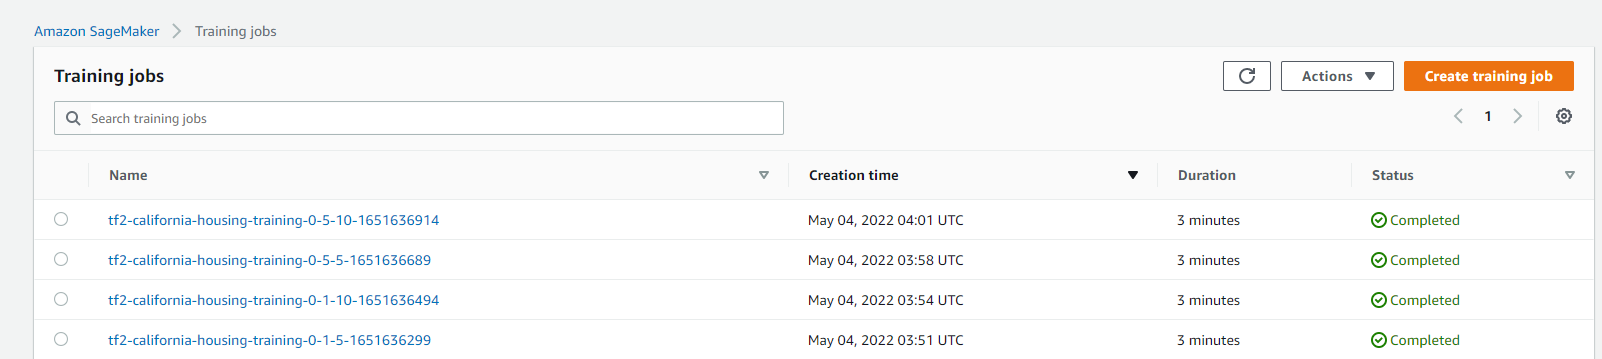

#### Compare the model training runs for an experiment

In [13]:
from sagemaker.analytics import ExperimentAnalytics

experiment_name = california_housing_experiment.experiment_name

trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=sagemaker_session, experiment_name=experiment_name
)
trial_comp_ds_jobs = trial_component_analytics.dataframe()
trial_comp_ds_jobs

,TrialComponentName,DisplayName,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,epochs,learning_rate,model_dir,...,test - MediaType,test - Value,train - MediaType,train - Value,SageMaker.DebugHookOutput - MediaType,SageMaker.DebugHookOutput - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value,Trials,Experiments
0,tf2-california-housing-training-0-5-10-1651636...,tf2-california-housing-training-0-5-10-1651636914,arn:aws:sagemaker:us-east-2:782329204437:train...,763104351884.dkr.ecr.us-east-2.amazonaws.com/t...,1.0,ml.m5.large,30.0,10.0,0.5,"""s3://sagemaker-us-east-2-782329204437/tf2-cal...",...,None,s3://sagemaker-us-east-2-782329204437/tf2-cali...,None,s3://sagemaker-us-east-2-782329204437/tf2-cali...,None,s3://sagemaker-us-east-2-782329204437/,None,s3://sagemaker-us-east-2-782329204437/tf2-cali...,[trial-tf2-california-housing-training-0-5-10-...,[tf2-california-housing-1651635763]
1,tf2-california-housing-training-0-5-5-16516366...,tf2-california-housing-training-0-5-5-1651636689,arn:aws:sagemaker:us-east-2:782329204437:train...,763104351884.dkr.ecr.us-east-2.amazonaws.com/t...,1.0,ml.m5.large,30.0,5.0,0.5,"""s3://sagemaker-us-east-2-782329204437/tf2-cal...",...,None,s3://sagemaker-us-east-2-782329204437/tf2-cali...,None,s3://sagemaker-us-east-2-782329204437/tf2-cali...,None,s3://sagemaker-us-east-2-782329204437/,None,s3://sagemaker-us-east-2-782329204437/tf2-cali...,[trial-tf2-california-housing-training-0-5-5-1...,[tf2-california-housing-1651635763]
2,tf2-california-housing-training-0-1-10-1651636...,tf2-california-housing-training-0-1-10-1651636494,arn:aws:sagemaker:us-east-2:782329204437:train...,763104351884.dkr.ecr.us-east-2.amazonaws.com/t...,1.0,ml.m5.large,30.0,10.0,0.1,"""s3://sagemaker-us-east-2-782329204437/tf2-cal...",...,None,s3://sagemaker-us-east-2-782329204437/tf2-cali...,None,s3://sagemaker-us-east-2-782329204437/tf2-cali...,None,s3://sagemaker-us-east-2-782329204437/,None,s3://sagemaker-us-east-2-782329204437/tf2-cali...,[trial-tf2-california-housing-training-0-1-10-...,[tf2-california-housing-1651635763]
3,tf2-california-housing-training-0-1-5-16516362...,tf2-california-housing-training-0-1-5-1651636299,arn:aws:sagemaker:us-east-2:782329204437:train...,763104351884.dkr.ecr.us-east-2.amazonaws.com/t...,1.0,ml.m5.large,30.0,5.0,0.1,"""s3://sagemaker-us-east-2-782329204437/tf2-cal...",...,None,s3://sagemaker-us-east-2-782329204437/tf2-cali...,None,s3://sagemaker-us-east-2-782329204437/tf2-cali...,None,s3://sagemaker-us-east-2-782329204437/,None,s3://sagemaker-us-east-2-782329204437/tf2-cali...,[trial-tf2-california-housing-training-0-1-5-1...,[tf2-california-housing-1651635763]


Let’s show the accuracy, epochs and optimizer. You will sort the results by accuracy descending.

In [14]:
trial_comp_ds_jobs = trial_comp_ds_jobs.sort_values("val_loss - Last", ascending=False)
trial_comp_ds_jobs[["TrialComponentName", "val_loss - Last", "epochs", "learning_rate"]]

,TrialComponentName,val_loss - Last,epochs,learning_rate
1,tf2-california-housing-training-0-5-5-16516366...,0.4642,5.0,0.5
0,tf2-california-housing-training-0-5-10-1651636...,0.3730,10.0,0.5
2,tf2-california-housing-training-0-1-10-1651636...,NaN,10.0,0.1
3,tf2-california-housing-training-0-1-5-16516362...,NaN,5.0,0.1


#### Visualize experiment

INFO:matplotlib.font_manager:Generating new fontManager, this may take some time...
INFO:numexpr.utils:NumExpr defaulting to 2 threads.


<AxesSubplot:xlabel='col_names'>

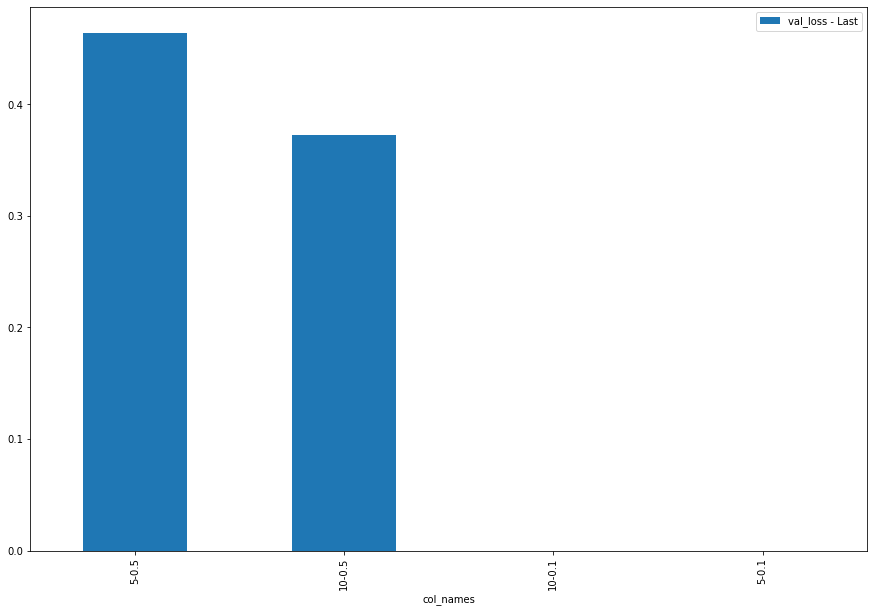

In [15]:
import matplotlib.pyplot as plt

trial_comp_ds_jobs["col_names"] = (
    trial_comp_ds_jobs["epochs"].astype("Int64").astype("str")
    + "-0."
    + ((trial_comp_ds_jobs["learning_rate"]) * 10).astype("Int64").astype("str")
)

fig = plt.figure()
fig.set_size_inches([15, 10])
trial_comp_ds_jobs.plot.bar("col_names", "val_loss - Last", ax=plt.gca())

#### Cleanup

In [16]:
def cleanup(experiment):
    for trial_summary in experiment.list_trials():
        trial = Trial.load(sagemaker_boto_client=sm, trial_name=trial_summary.trial_name)
        for trial_component_summary in trial.list_trial_components():
            tc = TrialComponent.load(
                sagemaker_boto_client=sm,
                trial_component_name=trial_component_summary.trial_component_name,
            )
            trial.remove_trial_component(tc)
            try:
                # comment out to keep trial components
                tc.delete()
            except:
                # tc is associated with another trial
                continue
            # to prevent throttling
            time.sleep(0.5)
        trial.delete()
    experiment.delete()

In [17]:
cleanup(california_housing_experiment)

In [19]:
bucket_to_delete = boto3.resource('s3').Bucket(bucket)
bucket_to_delete.objects.all().delete()

[{'ResponseMetadata': {'RequestId': '5C0VF6K6SVER91R6',
   'HostId': '5fnNuxN3A1VYmC49ITSGMeohphxM+JHPaLV4pCfHg3h7dSykYKwHVDm0pAkUgHBGZo7l7SAA09Q=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': '5fnNuxN3A1VYmC49ITSGMeohphxM+JHPaLV4pCfHg3h7dSykYKwHVDm0pAkUgHBGZo7l7SAA09Q=',
    'x-amz-request-id': '5C0VF6K6SVER91R6',
    'date': 'Wed, 04 May 2022 04:10:03 GMT',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3',
    'connection': 'close'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'tf2-california-housing-training-0-5-5-1651636689/debug-output/index/000000000/000000000323_worker_0.json'},
   {'Key': 'tf2-california-housing-training-0-5-10-1651636914/debug-output/events/000000001295/000000001295_worker_0.tfevents'},
   {'Key': 'tf2-california-housing-training-0-5-10-1651636914/debug-output/events/000000000647/000000000647_worker_0.tfevents'},
   {'Key': 'tf2-california-housing-training-0-5-10-1651636914/debug-output/index/